In [1]:
from vivino_community_reviews import save_reviews, load_reviews

In [2]:
import os
import pandas as pd

def read_csv(file, path_data, **kwargs):
    """
    kwargs: keyword args for pd.read_csv
    """
    files = [x for x in os.listdir(path_data) if x.startswith(file)]

    df_reviews = pd.DataFrame()
    for f in files:
        df = pd.read_csv(f'{path_data}/{f}', **kwargs)
        df_reviews = pd.concat([df_reviews, df])

    return df_reviews.reset_index(drop=True)

# Existing

In [21]:
file = 'wine_reviews_'
df_reviews = read_csv(file, 'data')
df_reviews.groupby(['wid', 'wine']).review_transl.count().sort_index(level=1)

wid  wine                                                
4    Aguirre Dos Copas Cabernet Sauvignon                      7
0    Casillero del Diablo Cabernet Sauvignon (Reserva)       472
6    Casillero del Diablo Chardonnay (Reserva)               122
11   Cono Sur Bicicleta Reserva Unoaked Chardonnay           109
9    Frontera Cabernet Sauvignon                             207
7    Kendall-Jackson Vintner's Reserve Cabernet Sauvignon    121
10   Long Barn Chardonnay                                    142
18   Montes Montes Alpha Cabernet Sauvignon                  220
2    Roche Mazet Cuvée Spéciale Cabernet Sauvignon            61
14   Roche Mazet Cuvée Spéciale Chardonnay                    31
16   San Pedro 1865 Selected Vineyards Cabernet Sauvignon     41
17   San Pedro 1865 Single Vineyard Cabernet Sauvignon        42
3    San Pedro Gato Negro Cabernet Sauvignon                 879
13   San Pedro Gato Negro Chardonnay                         230
5    The 7th Generation - G7 Cab

# Scraping

In [4]:
from vivino_community_reviews import vivino_reviews, concat_reviews

import pandas as pd

In [60]:
locator_ratings = "//a[@href='#all_reviews']"
locator_more = "//button[@tabindex='0']"
locator_recent = '//*[@data-testid="baseModalBackdrop"]/div[2]/div[2]/div[2]/div/a[1]'

locator_review = "communityReview__reviewText--2bfLj"
locator_date = "anchor_anchor__m8Qi- reviewAnchor__anchor--2NKFw reviewDate__reviewDate--49vpM undefined"

kwargs = {
    'loc1': locator_ratings,
    'loc2': locator_more,
    'loc3': locator_recent, 
    'loc4': locator_review,
    'loc5': locator_date
}

In [6]:
kwargs.update({
    'end_date': '20220101',
    'source': 'vivino',
    #'max_scr': 10, 'time_scr': 2, 'check_idx': 4
})

## wine list

In [6]:
w = """
Kendall-Jackson Vintner's Reserve Cabernet Sauvignon
https://www.vivino.com/kendall-jackson-vintner-s-reserve-cabernet-sauvignon/w/2140?ref=nav-search#all_reviews
Viña Santa Helena Reservado Cabernet Sauvignon'
https://www.vivino.com/vina-santa-helena-central-valley-reservado-cabernet-sauvignon/w/1134409?ref=nav-search#all_reviews
Frontera Cabernet Sauvignon
https://www.vivino.com/cl-frontera-cabernet-sauvignon/w/1135072?ref=nav-search#all_reviews
Long Barn Chardonnay
https://www.vivino.com/long-barn-chardonnay/w/3980079?ref=nav-search#all_reviews
Cono Sur Bicicleta Reserva Unoaked Chardonnay
https://www.vivino.com/cono-sur-santiago-bicicleta-reserva-unoaked-chardonnay-central-valley/w/6467244?ref=nav-search#all_reviews
The 7th Generation - G7 Chardonnay
https://www.vivino.com/the-7th-generation-chardonnay/w/1577653#all_reviews
San Pedro Gato Negro Chardonnay
https://www.vivino.com/san-pedro-central-valley-vspt-gato-negro-chardonnay/w/5956#all_reviews
Roche Mazet Cuvée Spéciale Chardonnay
https://www.vivino.com/fr-roche-mazet-cuvee-speciale-chardonnay/w/2332011?ref=nav-search#all_reviews
Yellow Tail Chardonnay
https://www.vivino.com/yellow-tail-chardonnay/w/2546?ref=nav-search#all_reviews
San Pedro 1865 Selected Vineyards Cabernet Sauvignon
https://www.vivino.com/san-pedro-central-valley-vspt-eighteen-sixtyfive-selected-vineyards-cabernet-sauvignon/w/6158938?ref=nav-search#all_reviews
San Pedro 1865 Single Vineyard Cabernet Sauvignon
https://www.vivino.com/san-pedro-central-valley-vspt-eighteen-sixtyfive-single-vineyard-cabernet-sauvignon/w/5900?ref=nav-search#all_reviews
Montes Montes Alpha Cabernet Sauvignon
https://www.vivino.com/montes-casablanca-valley-montes-alpha-cabernet-sauvignon/w/71294?ref=nav-search#all_reviews
"""

In [63]:
w = """
Montes Montes Alpha Merlot
https://www.vivino.com/montes-casablanca-valley-montes-alpha-merlot/w/71324?ref=nav-search
Montes Montes Alpha Syrah
https://www.vivino.com/montes-casablanca-valley-montes-alpha-syrah-colchagua-valley/w/10479900?ref=nav-search#all_reviews
San Pedro 1865 Selected Vineyards Syrah
https://www.vivino.com/san-pedro-central-valley-vspt-eighteen-sixtyfive-selected-vineyards-syrah-cachapoal/w/6371004#all_reviews
San Pedro 1865 Single Vineyard Malbec
https://www.vivino.com/san-pedro-central-valley-vspt-eighteen-sixtyfive-single-vineyard-malbec/w/1227330#all_reviews
San Pedro 1865 Single Vineyard Syrah
https://www.vivino.com/san-pedro-central-valley-vspt-eighteen-sixtyfive-single-vineyard-syrah/w/1226644#all_reviews
Mollydooker The Boxer Shiraz
https://www.vivino.com/mollydooker-winery-the-boxer-shiraz/w/950?ref=nav-search#all_reviews
William Hill North Coast Cabernet Sauvignon
https://www.vivino.com/william-hill-north-coast-cabernet-sauvignon-north-coast/w/2198238#all_reviews
William Hill North Coast Chardonnay
https://www.vivino.com/william-hill-north-coast-chardonnay-north-coast-white-wine-v-ihqmt/w/4609184?ref=nav-search#all_reviews
Kendall-Jackson Vintner's Reserve Chardonnay
https://www.vivino.com/kendall-jackson-vintner-s-reserve-chardonnay/w/2132?ref=nav-search#all_reviews
Bread & Butter Pinot Noir
https://www.vivino.com/bread-and-butter-pinot-noir/w/1724151?ref=nav-search#all_reviews
Bread & Butter Cabernet Sauvignon
https://www.vivino.com/bread-and-butter-cabernet-sauvignon-california-red-wine/w/6218579?ref=nav-search#all_reviews
"""

In [22]:
w = w.strip('\n').split('\n')
wines = {w[i]:w[i+1] for i in range(0, len(w), 2)}

id_start = df_reviews.wid.max() + 1
id_start

19

In [33]:
wines = {x[0]:x[1] for i,x in enumerate(wines.items()) if i >1}

**load the reviewsof the wines not translated yet**

In [7]:
#files = []
files = ['wine_6']
path = 'data'

df_reviews = pd.DataFrame()
for f in files:
    df = load_reviews(f'{f}.csv', path=path)
    df_reviews = pd.concat([df_reviews, df])

# check duplicate wid
df_reviews.groupby('wid').wine.unique()

data/wine_6.csv loaded.


wid
6    [Casillero del Diablo Chardonnay (Reserva)]
Name: wine, dtype: object

**reset dataframe if no reviews**

In [61]:
# selenium의 webdriver를 사용하기 위한 import
from selenium import webdriver

# selenium으로 키를 조작하기 위한 import
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

from selenium.common.exceptions import ElementNotVisibleException, StaleElementReferenceException, NoSuchElementException

# 페이지 로딩을 기다리는데에 사용할 time 모듈 import
import time

import pandas as pd 
import numpy as np
from tqdm import tqdm
from datetime import datetime

import os


def collect_reviews(class_name, driver, by=By.CLASS_NAME):
    l = driver.find_elements(by, class_name)
    return [x.text for x in l]
    

def vivino_reviews(wine_url, wine_name, 
                   end_date = '20230101',
                   max_rev = 1e4, 
                   max_scr = 10, # max num of scroll for new review list 
                   time_scr = 2, # time to wait after scrolling. StaleElementReferenceException if not enough
                   loc1=None, 
                   loc2=None, 
                   loc3=None, 
                   loc4=None, # class name
                   loc5=None, # class name
                   # take the final review list as the review page has same old reiviews at the end every update by scroll-down 
                   final_only = True,
                   check_idx = 4, # community review list has 3 old reviews at the end of list every loading of new reviews
                   rev_date_format = '%b %d, %Y',
                   #headless = False # fail to locate loc1 if set to True,
                   source='vivino'
                  ):

    #if headless:
    if False:
        options = webdriver.ChromeOptions()
        options.add_argument('headless')
    else:
        options = None

    driver = webdriver.Chrome(options=options) 
    driver.get(wine_url)
    time.sleep(3)

    loc4 = loc4.replace(' ', '.')
    loc5 = loc5.replace(' ', '.')

    try:
        # click all_reviews
        l = loc1
        driver.find_element(By.XPATH, loc1).click()
        
        # enter community reviews
        l = loc2
        driver.find_element(By.XPATH, loc2).click()
        time.sleep(1)
        
        # Show reviews by recent
        l = loc3
        driver.find_element(By.XPATH, loc3).click()
        time.sleep(1)

        l = loc4
        list_r = collect_reviews(loc4, driver)
        l = loc5
        list_d = collect_reviews(loc5, driver)
    except:
        print(f'ERROR) Check locator: {l}')
        driver.quit()
        return None
     
    reviews = list()
    dates = list()
    n_scr = 0

    #pbar = tqdm(total=max_rev, position=0)
    pbar = tqdm(position=0)
    
    while True:
        n = len(list_r) - len(reviews)
        if n > 0: # get new n reviews
            if final_only: # replace review list with the latest scan
                reviews = list_r
                dates = list_d
            else: # update review list with new reviews from the latest scan
                reviews.extend(list_r[-n:])
                dates.extend(list_d[-n:])
            n_scr = 0
            pbar.update(n)
        else:
            n_scr += 1

        # testing
        #return list_d

        d1 = datetime.strptime(list_d[-check_idx], rev_date_format)
        d2 = datetime.strptime(end_date, '%Y%m%d')
        #print('testing:', d1)

        if ((len(reviews) > max_rev) or (d1 < d2)):
            print(f'{len(reviews)} reviews collected.')
            break
        elif (n_scr > max_scr):
            # redundunt as n_try checking max_scr as well?
            print(f'WARNING: No additional reviews after {max_scr} reloading.')
            break
        else:
            driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
            time.sleep(time_scr)

            failed = True
            n_try = 0
            while failed:
                try:
                    list_r = collect_reviews(loc4, driver)
                    list_d = collect_reviews(loc5, driver)
                    failed = False
                except StaleElementReferenceException:
                    time.sleep(time_scr)
                    n_try += 1
                    
                if n_try > max_scr:
                    failed = False
                    print('WARNING: fail to collect all reviews')

    pbar.close()

    # close browser
    driver.quit()

    # save result
    df_reviews = pd.DataFrame.from_dict({'date':dates, 'review':reviews})
    df_reviews['date'] = pd.to_datetime(df_reviews['date'], format=rev_date_format)
    df_reviews['source'] = source
    
    if False: #deprecated
        df_reviews.to_csv(filename, index=False)  

    return df_reviews

In [64]:
df_reviews = pd.DataFrame()

In [65]:
col_rev = ['wid', 'wine', 'date', 'review', 'source']
path = 'data'

#for wine_name, wine_url in wines:
for wine_name, wine_url in wines.items():
    df = vivino_reviews(wine_url, wine_name, **kwargs)
    df_reviews = concat_reviews(df_reviews, df, wine_name, col_rev, path=path, id_start=id_start)
    break # testing

13it [00:00, 114550.32it/s]

13 reviews collected.
data/wine_19.csv saved.


In [27]:
from datetime import datetime
datetime.strptime("Jan 16, 2023", '%b %d, %Y')

datetime.datetime(2023, 1, 16, 0, 0)

In [41]:
dates, reviews = df

In [42]:
df_reviews = pd.DataFrame.from_dict({'date':dates, 'review':reviews})

In [43]:
df_reviews

,date,review
0,"May 20, 2023",맛있었음 적당한 감칠맛
1,"Jan 16, 2023",Too spicy for me
2,"Dec 24, 2022",좀 묽다
3,"Aug 1, 2022",too dry would be better with oilly food
4,"May 8, 2022",oak plum blackberry cherry
5,"Mar 6, 2022",검은과실 오크 바닐라 초콜릿 / 좋음 산미3-4 탄닌3 당도1-2 알콜4 (김치찌개...
6,"Feb 28, 2022",Nice
7,"Dec 30, 2021",가격 대비 무난한 시라 품종. 강렬한 스모크와 스파이스로 끝맛이 오래 남는 와인.
8,"Nov 27, 2021",Cereja
9,"Nov 20, 2021",blackberry plum cherry oak


In [53]:
x = df_reviews['date'][2]

from datetime import datetime
datetime.strptime(x, '%b %d, %Y')

datetime.datetime(2022, 12, 24, 0, 0)

In [51]:
pd.to_datetime(df_reviews['date'])

ValueError: time data "Jan 16, 2023" doesn't match format "%B %d, %Y", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

**temp saving before translation**

In [25]:
df_reviews

,wid,wine,date,review,source
0,19,Montes Montes Alpha Merlot,2024-02-05,Enjoyed it with chicken tikka masala as its so...,vivino
1,19,Montes Montes Alpha Merlot,2023-12-31,"Vintage 2021 very smooth, Well balanced with v...",vivino
2,19,Montes Montes Alpha Merlot,2023-11-26,oak plum tobacco Slightly bitter Worth of pric...,vivino
3,19,Montes Montes Alpha Merlot,2023-11-24,.,vivino
4,19,Montes Montes Alpha Merlot,2023-11-23,easy to drink table top merlot. it does not pr...,vivino
...,...,...,...,...,...
48,20,Montes Montes Alpha Syrah,2024-01-27,"Delicioso Syrah. No aroma, blueberry, amora, c...",vivino
49,20,Montes Montes Alpha Syrah,2024-01-27,Very good,vivino
50,20,Montes Montes Alpha Syrah,NaT,,vivino
51,20,Montes Montes Alpha Syrah,2023-05-12,"Was out for supper with a friend, this was the...",vivino


In [13]:
save_reviews(df_reviews, 'wine_reviews_tmp.csv', 'data')

data/wine_reviews.csv saved.


# Review data

In [14]:
df_reviews = load_reviews('wine_reviews_tmp.csv', 'data')

data/wine_reviews.csv loaded.


In [15]:
cond = (df_reviews.date.isna()) | (df_reviews.review.isna())
df_reviews.loc[cond]

,wid,wine,date,review,source
120,6,Casillero del Diablo Chardonnay (Reserva),NaT,NaN,vivino
243,7,Kendall-Jackson Vintner's Reserve Cabernet Sau...,2022-04-09,NaN,vivino
296,8,Viña Santa Helena Reservado Cabernet Sauvignon',NaT,NaN,vivino
297,8,Viña Santa Helena Reservado Cabernet Sauvignon',2022-07-23,NaN,vivino
475,9,Frontera Cabernet Sauvignon,2022-02-23,NaN,vivino
480,9,Frontera Cabernet Sauvignon,2022-02-15,NaN,vivino
495,9,Frontera Cabernet Sauvignon,2022-01-16,NaN,vivino
509,9,Frontera Cabernet Sauvignon,NaT,NaN,vivino
652,10,Long Barn Chardonnay,NaT,NaN,vivino
724,11,Cono Sur Bicicleta Reserva Unoaked Chardonnay,2022-02-13,NaN,vivino


In [16]:
df_reviews = df_reviews.loc[~cond].reset_index(drop=True)

In [17]:
df_reviews.date.dt.year.value_counts().sort_index(ascending=False)

date
2024     56
2023    501
2022    745
2021    165
2020     13
2019      2
2018      3
2016      2
Name: count, dtype: int64

In [19]:
kwargs['end_date']

'20220101'

<Axes: >

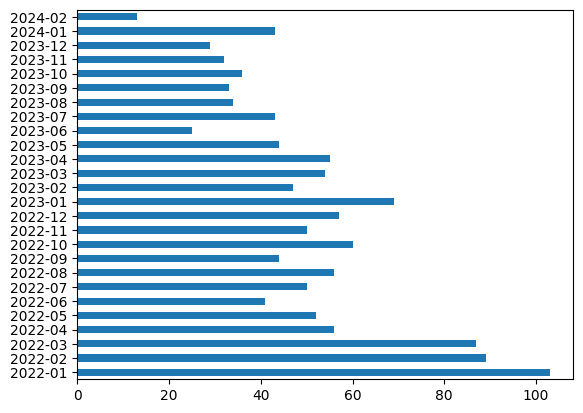

In [22]:
#d = df_reviews.date.agg(['min', 'max']).to_list()
d = [kwargs['end_date'], df_reviews.date.max()]

date_range = pd.date_range(start=d[0], end=d[1]).to_period("M").unique()

(df_reviews
 .set_index('date').to_period("M")
 .groupby(level=0).review.count()
 .sort_index()
 .reindex(date_range, fill_value=0)
 .plot(kind='barh')
)

<Axes: ylabel='wine'>

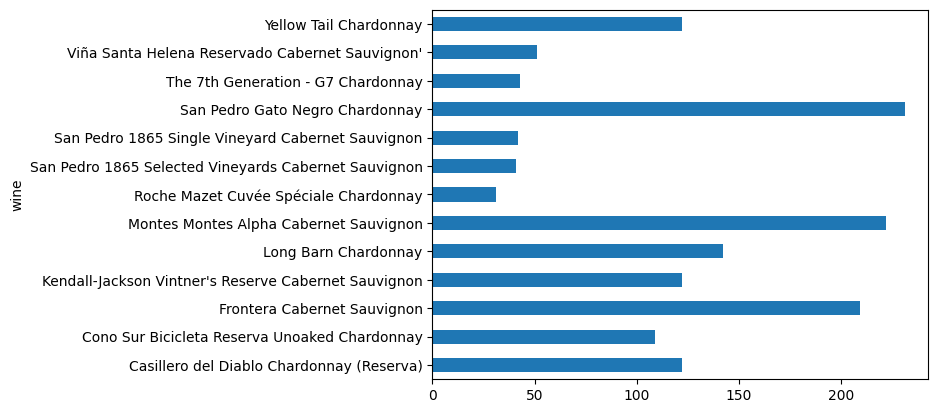

In [23]:
(df_reviews
 .groupby(by='wine').review.count()
 .plot(kind='barh')
)

In [24]:
df_reviews.head()

,wid,wine,date,review,source
0,6,Casillero del Diablo Chardonnay (Reserva),2024-02-03,"cu 1.6 구매, 소비뇽블랑같은 맛",vivino
1,6,Casillero del Diablo Chardonnay (Reserva),2024-02-02,Chardonnay da onipresente Concha y Toro. É agr...,vivino
2,6,Casillero del Diablo Chardonnay (Reserva),2024-01-29,Aroma de pêssego bem presente!! Harmoniza bem ...,vivino
3,6,Casillero del Diablo Chardonnay (Reserva),2024-01-26,"It's a pretty rough Chardonnay, unbalanced and...",vivino
4,6,Casillero del Diablo Chardonnay (Reserva),2024-01-01,Bom custo beneficio,vivino


# Translate

In [25]:
import langdetect
import json
from deep_translator import GoogleTranslator
from tqdm import tqdm

def detect_language(text):
    try:
        return langdetect.detect(text)
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

def get_translation(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

In [26]:
tmp_data = []

for rec in tqdm(df_reviews.to_dict('records')):
    tmp_data.append({
        #'wid': rec['wid'],
        'lang': detect_language(rec['review']),
        'review_transl': get_translation(rec['review'])
    })

100%|███████████████████████████████████████████████████████████| 1487/1487 [19:30<00:00,  1.27it/s]


In [27]:
df_reviews = df_reviews.merge(pd.DataFrame(tmp_data), left_index=True, right_index=True)
df_reviews.head()

,wid,wine,date,review,source,lang,review_transl
0,6,Casillero del Diablo Chardonnay (Reserva),2024-02-03,"cu 1.6 구매, 소비뇽블랑같은 맛",vivino,ko,"Purchased cu 1.6, tastes like sauvignon blanc"
1,6,Casillero del Diablo Chardonnay (Reserva),2024-02-02,Chardonnay da onipresente Concha y Toro. É agr...,vivino,pt,Chardonnay from the ubiquitous Concha y Toro. ...
2,6,Casillero del Diablo Chardonnay (Reserva),2024-01-29,Aroma de pêssego bem presente!! Harmoniza bem ...,vivino,pt,Peach aroma very present!! Pairs well with sea...
3,6,Casillero del Diablo Chardonnay (Reserva),2024-01-26,"It's a pretty rough Chardonnay, unbalanced and...",vivino,en,"It's a pretty rough Chardonnay, unbalanced and..."
4,6,Casillero del Diablo Chardonnay (Reserva),2024-01-01,Bom custo beneficio,vivino,en,Good cost-benefit


**check translation error**

In [ ]:
df_reviews.loc[df_reviews.lang.str.contains('ERROR')]

In [ ]:
cond = df_reviews.review_transl.isna()
df_reviews.loc[cond]

In [ ]:
#df_reviews = df_reviews.loc[~cond]

**save final data**

In [28]:
from datetime import datetime
d = datetime.today().strftime('%y%m%d')
save_reviews(df_reviews, f'wine_reviews_{d}.csv')

data/wine_reviews_240207.csv saved.


In [31]:
!zip -j wine_reviews.zip data/wine_reviews_2*csv

  adding: wine_reviews_240124.csv (deflated 70%)
  adding: wine_reviews_240207.csv (deflated 69%)
